In [1]:

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import scipy.misc # v1.1.0
import skimage.transform
from sklearn.model_selection import train_test_split
import tensorflow as tf
from functools import partial
from math import ceil
import sys
import os


In [2]:
scipy


<module 'scipy' from 'C:\\Users\\ahsteven\\AppData\\Local\\Continuum\\anaconda3\\envs\\tf-gpu\\lib\\site-packages\\scipy\\__init__.py'>

In [3]:

# Importing the dataset
good_root_dir = 'Images/good/'
good_folders = ['baseline 1500 Watts test', 'Coil no power', 
         'Ramp_1', 'Ramp_2', 'Test2',
               'Coil off test3','Coil off test4',
               'Coil off test6']
all_normal_path = [good_root_dir +j for j in good_folders]
# get anomoly image directories
anomoly_root_dir = 'Images/anomolies/'
anomoly_folders = ['hand_1', 'hand_2', 'metal_object', 'screws',
                   'soda_ramp_500', 'soda_ramp_1000', 'soda_ramp_1500']
all_anomoly_path = [anomoly_root_dir + j for j in anomoly_folders]

# normal_names = glob.glob(normal +'*.png')
normal_names = []
for n in all_normal_path:
    normal_names.append(glob.glob(n +'/'+ '*.png'))
normal_names = np.concatenate(normal_names)

anomoly_names = []
for an in all_anomoly_path:
    anomoly_names.append(glob.glob(an +'/'+ '*.png'))
anomoly_names = np.concatenate(anomoly_names)



# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)

# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
# sess = tf.Session(config=config)


In [4]:
learning_rate = .00005
l2_reg = .001
batch_size = 32
n_batches = ceil(len(normal_names)/batch_size)
image_size = (60, 80, 3)

In [5]:
len(anomoly_names)

298

In [6]:
len(normal_names)

500

In [7]:
good_labels = np.zeros((len(normal_names),1))
anomoly_labels = np.ones((len(anomoly_names),1))
labels = np.vstack((good_labels, anomoly_labels))
images = np.append(normal_names, anomoly_names)

In [8]:
g_train, g_test = train_test_split(normal_names, test_size=0.15, random_state=41)
a_train, a_test = train_test_split(anomoly_names, test_size=0.15, random_state=41)

In [9]:

# to read in all the images without generator
def read_imgs(imgs, flatten = False, image_size= (60, 80, 3),  rand_flip = True):
    """
    Read in list of images, return np array 
    :param imgs: list of image names to read in
    :param flatten: if True flatten image
    :return: np array of images
    """
#     random.shuffle(imgs)
    imgs_noise = []
    images = []
    for image_file in imgs:

        image = scipy.misc.imresize(scipy.misc.imread(image_file), (image_size[0], image_size[1]), interp="nearest")
#         image = skimage.transform.resize(skimage.io.imread(image_file), (image_size[0], image_size[1]))
#         print("image shape ", image.shape)
        if flatten:
            image = image.flatten()
            
        image = image/255.0

        noise = add_noise(image)
            
        if rand_flip:
            if np.random.uniform(0, 1) > .5:
                noise = np.fliplr(noise)
                image = np.fliplr(image)
                    
        imgs_noise.append(noise)            
        images.append(image)
        
    return np.array(images), np.array(imgs_noise)

def add_noise(image, mean=0, std=.1):
    gauss = np.random.normal(mean, std, (image.shape))
    noisy = image + gauss
    noisy=np.clip(noisy, 0, 1)
    return noisy
    

C:\Users\ahsteven\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
C:\Users\ahsteven\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


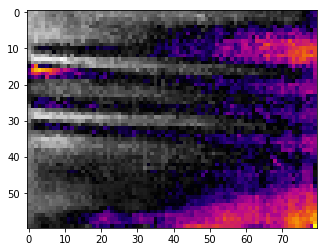

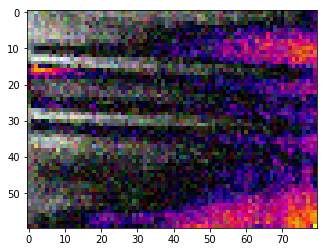

In [10]:
img, noisy = read_imgs([g_train[0]])
plt.imshow(img[0])
plt.show()
plt.imshow(noisy[0])

### Build Graph

In [11]:
tf.reset_default_graph()
he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

optimizer = tf.train.RMSPropOptimizer(learning_rate)

X_orig = tf.placeholder(tf.float32, shape=[None, image_size[0], image_size[1], image_size[2]], name="X_orig")
X_noise = tf.placeholder(tf.float32, shape=[None, image_size[0], image_size[1], image_size[2]], name="X_noise")

with tf.name_scope("phase1"):
    conv1_p1 = tf.layers.conv2d(
        inputs=X_noise,
        filters=64,
        strides = (4, 4),
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.tanh,
        kernel_initializer=he_init,
        kernel_regularizer=l2_regularizer,
        reuse=False,
        name="conv1")
    print("conv1_p1 ", conv1_p1.get_shape().as_list())
    outputs_p1 = tf.layers.conv2d_transpose(
        inputs=conv1_p1,
        filters=3,
        strides = (4, 4),
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.sigmoid,
        kernel_initializer=he_init,
        kernel_regularizer=l2_regularizer,
        reuse=False,
        name="outputs")
    print("outputs_p1 ", outputs_p1.get_shape().as_list())   
#     print(tf.trainable_variables(scope='phase1'))
    

#     phase1_names = ['conv1/kernel:0', 'conv1/bias:0', 'outputs/kernel:0', 'outputs/bias:0']
#     phase1_train_vars = [v for v in all_variables if v.name in phase1_names ]
#     print("phase1 trainable variables ", phase1_train_vars)
#     phase1_loss_collection = [item for item in tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES) 
#         if 'conv1/kernel' in item.name or 'outputs/kernel' in item.name]
#     print("phase1_loss_collection", phase1_loss_collection)
#     phase1_reg_loss = tf.reduce_sum(phase1_loss_collection)
# #     phase1_reg_loss = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
#     phase1_recon_loss = tf.reduce_mean(tf.square(outputs_p1 - X))
#     phase1_loss = phase1_reg_loss + phase1_recon_loss
# #     phase1_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "phase1")#only update phase1 weights
#     phase1_training_op = optimizer.minimize(phase1_loss, var_list=phase1_train_vars)
    
with tf.name_scope("phase2"):   
    conv2_p2 = tf.layers.conv2d(
        inputs=conv1_p1,
        filters=64,
        strides = (2, 2),
        kernel_size=[3, 3],
        kernel_initializer=he_init,
        kernel_regularizer=l2_regularizer,
        padding="same",
        activation=tf.nn.tanh,
        reuse=False,
        name="conv2")
    print("conv2_p2 ", conv2_p2.get_shape().as_list())
    
    conv1_shape = conv1_p1.get_shape().as_list()
    conv1_dec_p2 = tf.layers.conv2d_transpose(
        inputs=conv2_p2,
        filters=64,
        strides = (2, 2),
        kernel_size=[5, 5],
        padding="same",
        kernel_initializer=he_init,
        kernel_regularizer=l2_regularizer,
        activation=tf.nn.tanh,
        reuse=False,
        name="conv1_dec")
    print("conv1_dec_p2 ", conv1_dec_p2.get_shape().as_list())
    conv1_shape = conv1_p1.get_shape().as_list()
    reshape1_p2 = tf.image.resize_images(conv1_dec_p2,
                                      size=(conv1_shape[1],conv1_shape[2]),
                                      method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    print("reshape1_p2\ ", reshape1_p2.get_shape().as_list())
    
#     #get phase2 trainable variables
#     phase2_names = ['conv2/kernel:0', 'conv2/bias:0', 'conv1_dec/kernel:0', 'conv1_dec/bias:0']
#     phase2_train_vars = [v for v in all_variables if v.name in phase2_names ]
#     print("phase2 trainable variables ", phase2_train_vars)
#     phase2_loss_collection = [item for item in tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES) 
#         if 'conv2/kernel' in item.name or 'conv1_dec/kernel' in item.name]
#     print("phase2_loss_collection", phase2_loss_collection)
#     phase2_reg_loss = tf.reduce_sum(phase2_loss_collection)
    
# #     phase2_reg_loss = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 'phase2'))
#     phase2_recon_loss = tf.reduce_mean(tf.square(reshape1_p2 - conv1_p1))
#     phase2_loss = phase2_reg_loss + phase2_recon_loss
# #     phase2_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "phase2")
#     phase2_training_op = optimizer.minimize(phase2_loss, var_list=phase2_train_vars)

with tf.name_scope("phase3"):
    conv3_p3 = tf.layers.conv2d(
        inputs=conv2_p2,
        filters=64,
        strides = (2, 2),
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.tanh,
        kernel_initializer=he_init,
        kernel_regularizer=l2_regularizer,
        reuse=False,
        name="conv3")
    print("conv3_p3 ", conv3_p3.get_shape().as_list())
    conv2_dec_p3 = tf.layers.conv2d_transpose(
        inputs=conv3_p3,
        filters=64,
        strides = (2, 2),
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.tanh,
        kernel_initializer=he_init,
        kernel_regularizer=l2_regularizer,
        reuse=False,
        name="conv2_dec")
    print("conv2_dec_p3 ", conv2_dec_p3.get_shape().as_list())
    conv2_shape = conv2_p2.get_shape().as_list()
    reshape2_p3 = tf.image.resize_images(conv2_dec_p3,
                                       size=(conv2_shape[1],conv2_shape[2]), 
                                       method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)    
    print("reshape2_p3\ ", reshape2_p3.get_shape().as_list())
    
    
#     #get phase3 trainable variables
#     phase3_names = ['conv3/kernel:0', 'conv3/bias:0', 'conv2_dec/kernel:0', 'conv2_dec/bias:0']
#     phase3_train_vars = [v for v in all_variables if v.name in phase3_names ]
#     print("phase3 trainable variables ", phase3_train_vars)
#     phase3_loss_collection = [item for item in tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES) 
#         if 'conv3/kernel' in item.name or 'conv2_dec/kernel' in item.name]
#     print("phase3_loss_collection", phase3_loss_collection)
#     phase3_reg_loss = tf.reduce_sum(phase3_loss_collection)    
# #     phase3_reg_loss = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 'phase3'))
#     phase3_recon_loss = tf.reduce_mean(tf.square(reshape2_p3 - conv2_p2))
#     phase3_loss = phase3_reg_loss + phase3_recon_loss
# #     phase3_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "phase3")
#     phase3_training_op = optimizer.minimize(phase3_loss, var_list=phase3_train_vars)

# phase 4 not necessary, could just train full network 
with tf.name_scope("phase4"):
    encoded_p4 = tf.layers.conv2d(
    inputs=conv3_p3,
    filters=64,
    strides = (1, 1),
    kernel_size=[1, 1],
    padding="same",
    activation=tf.nn.tanh,
    kernel_initializer=he_init,
    kernel_regularizer=l2_regularizer,
    reuse = False,
    name="encoded")
    print("encoded ", encoded_p4.get_shape().as_list())
    conv3_shape = conv3_p3.get_shape().as_list()
    conv3_dec_p4 = tf.layers.conv2d_transpose(
        inputs=encoded_p4,
        filters=64,
        strides = (2, 2),
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.tanh,
        kernel_initializer=he_init,
        kernel_regularizer=l2_regularizer,
        reuse=False,
        name="conv3_dec")
    print("conv3_dec_p4 ", conv3_dec_p4.get_shape().as_list())
    reshape3_p4 = tf.image.resize_images(conv3_dec_p4,
                                       size=(conv3_shape[1],conv3_shape[2]), 
                                       method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    print("reshape3_p4 ", reshape3_p4.get_shape().as_list()) 

#     #get phase4 trainable variables
#     phase4_names = ['encoded/kernel:0', 'encoded/bias:0', 'conv3_dec/kernel:0', 'conv3_dec/bias:0']
#     phase4_train_vars = [v for v in all_variables if v.name in phase4_names ]
#     print("phase4 trainable variables ", phase4_train_vars)
#     phase4_loss_collection = [item for item in tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES) 
#         if 'conv3_dec/kernel' in item.name or  'encoded/kernel' in item.name]
#     print("phase4_loss_collection", phase4_loss_collection)
#     phase4_reg_loss = tf.reduce_sum(phase4_loss_collection) 
# #     phase4_reg_loss = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 'phase4'))
#     phase4_recon_loss = tf.reduce_mean(tf.square(reshape3_p4 - conv3_p3))
#     phase4_loss = phase4_reg_loss + phase4_recon_loss
# #     phase4_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "phase4")
#     phase4_training_op = optimizer.minimize(phase4_loss, var_list=phase4_train_vars)
    
    


conv1_p1  [None, 15, 20, 64]
outputs_p1  [None, 60, 80, 3]
conv2_p2  [None, 8, 10, 64]
conv1_dec_p2  [None, 16, 20, 64]
reshape1_p2\  [None, 15, 20, 64]
conv3_p3  [None, 4, 5, 64]
conv2_dec_p3  [None, 8, 10, 64]
reshape2_p3\  [None, 8, 10, 64]
encoded  [None, 4, 5, 64]
conv3_dec_p4  [None, 8, 10, 64]
reshape3_p4  [None, 4, 5, 64]


In [12]:

all_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

phase1_names = ['conv1/kernel:0', 'conv1/bias:0', 'outputs/kernel:0', 'outputs/bias:0']
phase1_train_vars = [v for v in all_variables if v.name in phase1_names ]
print("phase1 trainable variables ", phase1_train_vars)
phase1_loss_collection = [item for item in tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES) 
    if 'conv1/kernel' in item.name or 'outputs/kernel' in item.name]
print("phase1_loss_collection", phase1_loss_collection)
phase1_reg_loss = tf.reduce_sum(phase1_loss_collection)
#     phase1_reg_loss = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
phase1_recon_loss = tf.reduce_mean(tf.abs(outputs_p1 - X_orig))
phase1_loss = phase1_reg_loss + phase1_recon_loss
#     phase1_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "phase1")#only update phase1 weights
phase1_training_op = optimizer.minimize(phase1_loss, var_list=phase1_train_vars)

#get phase2 trainable variables
phase2_names = ['conv2/kernel:0', 'conv2/bias:0', 'conv1_dec/kernel:0', 'conv1_dec/bias:0']
phase2_train_vars = [v for v in all_variables if v.name in phase2_names ]
print("phase2 trainable variables ", phase2_train_vars)
phase2_loss_collection = [item for item in tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES) 
    if 'conv2/kernel' in item.name or 'conv1_dec/kernel' in item.name]
print("phase2_loss_collection", phase2_loss_collection)
phase2_reg_loss = tf.reduce_sum(phase2_loss_collection)

#     phase2_reg_loss = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 'phase2'))
phase2_recon_loss = tf.reduce_mean(tf.abs(reshape1_p2 - conv1_p1))
phase2_loss = phase2_reg_loss + phase2_recon_loss
#     phase2_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "phase2")
phase2_training_op = optimizer.minimize(phase2_loss, var_list=phase2_train_vars)

#get phase3 trainable variables
phase3_names = ['conv3/kernel:0', 'conv3/bias:0', 'conv2_dec/kernel:0', 'conv2_dec/bias:0']
phase3_train_vars = [v for v in all_variables if v.name in phase3_names ]
print("phase3 trainable variables ", phase3_train_vars)
phase3_loss_collection = [item for item in tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES) 
    if 'conv3/kernel' in item.name or 'conv2_dec/kernel' in item.name]
print("phase3_loss_collection", phase3_loss_collection)
phase3_reg_loss = tf.reduce_sum(phase3_loss_collection)    
#     phase3_reg_loss = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 'phase3'))
phase3_recon_loss = tf.reduce_mean(tf.abs(reshape2_p3 - conv2_p2))
phase3_loss = phase3_reg_loss + phase3_recon_loss
#     phase3_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "phase3")
phase3_training_op = optimizer.minimize(phase3_loss, var_list=phase3_train_vars)

#get phase4 trainable variables
phase4_names = ['encoded/kernel:0', 'encoded/bias:0', 'conv3_dec/kernel:0', 'conv3_dec/bias:0']
phase4_train_vars = [v for v in all_variables if v.name in phase4_names ]
print("phase4 trainable variables ", phase4_train_vars)
phase4_loss_collection = [item for item in tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES) 
    if 'conv3_dec/kernel' in item.name or  'encoded/kernel' in item.name]
print("phase4_loss_collection", phase4_loss_collection)
phase4_reg_loss = tf.reduce_sum(phase4_loss_collection) 
#     phase4_reg_loss = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 'phase4'))
phase4_recon_loss = tf.reduce_mean(tf.abs(reshape3_p4 - conv3_p3))
phase4_loss = phase4_reg_loss + phase4_recon_loss
#     phase4_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "phase4")
phase4_training_op = optimizer.minimize(phase4_loss, var_list=phase4_train_vars)

phase1 trainable variables  [<tf.Variable 'conv1/kernel:0' shape=(5, 5, 3, 64) dtype=float32_ref>, <tf.Variable 'conv1/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'outputs/kernel:0' shape=(5, 5, 3, 64) dtype=float32_ref>, <tf.Variable 'outputs/bias:0' shape=(3,) dtype=float32_ref>]
phase1_loss_collection [<tf.Tensor 'phase1/conv1/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'phase1/outputs/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>]
phase2 trainable variables  [<tf.Variable 'conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>, <tf.Variable 'conv2/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'conv1_dec/kernel:0' shape=(5, 5, 64, 64) dtype=float32_ref>, <tf.Variable 'conv1_dec/bias:0' shape=(64,) dtype=float32_ref>]
phase2_loss_collection [<tf.Tensor 'phase2/conv2/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>, <tf.Tensor 'phase2/conv1_dec/kernel/Regularizer/l2_regularizer:0' shape=() dtype=float32>]
phase3 

In [13]:
def forward(im_noise, im):
#     tf.get_variable_scope().reuse_variables()
    conv1 = tf.layers.conv2d(
        inputs=im_noise,
        filters=64,
        strides = (4, 4),
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.tanh,
        kernel_initializer=he_init,
        kernel_regularizer=l2_regularizer,
        reuse=True,
        name="conv1")
    print("conv1 ", conv1.get_shape().as_list())

    conv2 = tf.layers.conv2d(
        inputs=conv1,
        filters=64,
        strides = (2, 2),
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.tanh,
        kernel_initializer=he_init,
        kernel_regularizer=l2_regularizer,
        reuse=True,
        name="conv2")
    print("conv2 ", conv2.get_shape().as_list())

    conv3 = tf.layers.conv2d(
        inputs=conv2,
        filters=64,
        strides = (2, 2),
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.tanh,
        kernel_initializer=he_init,
        kernel_regularizer=l2_regularizer,
        reuse=True,
        name="conv3")
    print("conv3 ", conv3.get_shape().as_list())

    encoded = tf.layers.conv2d(
        inputs=conv3,
        filters=64,
        strides = (1, 1),
        kernel_size=[1, 1],
        padding="same",
        activation=tf.nn.tanh,
        kernel_initializer=he_init,
        kernel_regularizer=l2_regularizer,
        reuse=True,
        name="encoded")
    print("encoded ", encoded.get_shape().as_list())

    conv3_shape = conv3.get_shape().as_list()
    conv3_dec = tf.layers.conv2d_transpose(
        inputs=encoded,
        filters=64,
        strides = (2, 2),
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.tanh,
        kernel_initializer=he_init,
        kernel_regularizer=l2_regularizer,
        reuse=True,
        name="conv3_dec")
#     print("conv3_dec ", conv3_dec.get_shape().as_list())

    reshape3 = tf.image.resize_images(conv3_dec,
                                       size=(conv3_shape[1],conv3_shape[2]), 
                                       method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    print("reshape3 ", reshape3.get_shape().as_list())
    conv2_dec = tf.layers.conv2d_transpose(
        inputs=reshape3,
        filters=64,
        strides = (2, 2),
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.tanh,
        kernel_initializer=he_init,
        kernel_regularizer=l2_regularizer,
        reuse=True,
        name="conv2_dec")
#     print("conv2_dec ", conv2_dec.get_shape().as_list())
    conv2_shape = conv2.get_shape().as_list()
    reshape2 = tf.image.resize_images(conv2_dec,
                                       size=(conv2_shape[1],conv2_shape[2]), 
                                       method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    print("reshape2 ", reshape2.get_shape().as_list())

    conv1_shape = conv1.get_shape().as_list()
    conv1_dec = tf.layers.conv2d_transpose(
        inputs=reshape2,
        filters=64,
        strides = (2, 2),
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.tanh,
        kernel_initializer=he_init,
        kernel_regularizer=l2_regularizer,
        reuse=True,
        name="conv1_dec")
    # print("conv1_dec ", conv1_dec.get_shape().as_list())
    reshape1 = tf.image.resize_images(conv1_dec,
                                       size=(conv1_shape[1],conv1_shape[2]), 
                                       method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    print("reshape1 ", reshape1.get_shape().as_list())

    outputs = tf.layers.conv2d_transpose(
        inputs=reshape1,
        filters=3,
        strides = (4, 4),
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.sigmoid,
        kernel_initializer=he_init,
        kernel_regularizer=l2_regularizer,
        reuse=True,
        name="outputs")
    print("outputs ", outputs.get_shape().as_list())


    ### For training complete graph    
    reg_loss = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
    recon_loss = tf.reduce_mean(tf.abs(outputs - im), name='recon_loss')
    loss = reg_loss + recon_loss

    return encoded, outputs, recon_loss, loss

In [14]:
[var.name for var in tf.global_variables()]

['conv1/kernel:0',
 'conv1/bias:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'conv2/kernel:0',
 'conv2/bias:0',
 'conv1_dec/kernel:0',
 'conv1_dec/bias:0',
 'conv3/kernel:0',
 'conv3/bias:0',
 'conv2_dec/kernel:0',
 'conv2_dec/bias:0',
 'encoded/kernel:0',
 'encoded/bias:0',
 'conv3_dec/kernel:0',
 'conv3_dec/bias:0',
 'conv1/kernel/RMSProp:0',
 'conv1/kernel/RMSProp_1:0',
 'conv1/bias/RMSProp:0',
 'conv1/bias/RMSProp_1:0',
 'outputs/kernel/RMSProp:0',
 'outputs/kernel/RMSProp_1:0',
 'outputs/bias/RMSProp:0',
 'outputs/bias/RMSProp_1:0',
 'conv2/kernel/RMSProp:0',
 'conv2/kernel/RMSProp_1:0',
 'conv2/bias/RMSProp:0',
 'conv2/bias/RMSProp_1:0',
 'conv1_dec/kernel/RMSProp:0',
 'conv1_dec/kernel/RMSProp_1:0',
 'conv1_dec/bias/RMSProp:0',
 'conv1_dec/bias/RMSProp_1:0',
 'conv3/kernel/RMSProp:0',
 'conv3/kernel/RMSProp_1:0',
 'conv3/bias/RMSProp:0',
 'conv3/bias/RMSProp_1:0',
 'conv2_dec/kernel/RMSProp:0',
 'conv2_dec/kernel/RMSProp_1:0',
 'conv2_dec/bias/RMSProp:0',
 'conv2_dec/bias/RMSPro

In [15]:
 
init = tf.global_variables_initializer()
saver = tf.train.Saver()


In [16]:

training_ops = [phase1_training_op, phase2_training_op, phase3_training_op, phase4_training_op]
reconstruction_losses = [phase1_recon_loss, phase2_recon_loss, phase3_recon_loss, phase4_recon_loss]

# graph = tf.get_default_graph()

# sess = tf.InteractiveSession()

def train_phases(imgs, checkpoint_file= None):
    training_ops = [phase1_training_op, phase2_training_op, phase3_training_op, phase4_training_op]
    reconstruction_losses = [phase1_recon_loss, phase2_recon_loss, phase3_recon_loss, phase4_recon_loss]
    n_epochs = [100, 100,100,100]
#     n_epochs = [1,1,1,1]
    batch_sizes = [32, 32,32,32]
    graph = tf.get_default_graph() 
    
#     with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    with tf.Session(config=config) as sess:
        if checkpoint_file:
            saver.restore(sess, checkpoint_file)
        else:
            init.run()

        for phase in range(4):
            print("Training phase #{}".format(phase + 1))
            for epoch in range(n_epochs[phase]):

                for batch_i in range(0, len(imgs), batch_size):
                    X_, X_n = read_imgs(imgs[batch_i:batch_i + batch_size])
                    X_ = X_.astype(np.float32)
                    X_n = X_n.astype(np.float32)
                    sess.run(training_ops[phase], feed_dict={X_noise: X_n, X_orig: X_ })

                loss_train = reconstruction_losses[phase].eval(feed_dict={X_noise: X_n, X_orig: X_ })
                print("\r{}".format(epoch), "Train MSE:", loss_train)

                saver.save(sess, "./checkpoints/test_4_phases_L1.ckpt")
                


In [17]:
def train_all(imgs, batch_size=32, checkpoint_file= None, n_epochs=1):
    
    with tf.Session(config=config) as sess:
        if checkpoint_file:
            saver.restore(sess, checkpoint_file)
        else:
            init.run()
        good_in = tf.placeholder(tf.float32, shape=[None, image_size[0], image_size[1], image_size[2]], name="good_in")
        good_noise = tf.placeholder(tf.float32, shape=[None, image_size[0], image_size[1], image_size[2]], name="good_noise")

        encoded, outputs, recon_loss, loss = forward(good_noise, good_in)
            
            
        for epoch in range(n_epochs):
            for batch_i in range(0, len(imgs), batch_size):
#             for X_batch,y_batch in get_batches_fn(X, y, batch_size):
#                 y_batch = labels[batch_i:batch_i + batch_size].astype(np.float16)
#                 X_batch = read_imgs(imgs[batch_i:batch_i + batch_size]).astype(np.float32)
                normal, normal_noisy = read_imgs(imgs[batch_i:batch_i + batch_size], flatten=False, rand_flip=True) 
#                 print("y" , y_batch.shape)
#                 print("x" , X_batch.shape)
#                 sess.run(training_op, feed_dict={X: X_batch, y:0})

                normal = normal.astype(np.float32)
                normal_noisy = normal_noisy.astype(np.float32)
                op = optimizer.minimize(loss)
                sess.run([op], feed_dict={good_in:normal, good_noise:normal_noisy})
            loss_train = recon_loss.eval(feed_dict={good_in:normal, good_noise:normal_noisy})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./checkpoints/test_4.ckpt", global_step=50)
        saver.save(sess, "./checkpoints/test_4_fina1.ckpt")

### train on normal images first

In [ ]:
# train_all(g_train,  n_epochs=200)


In [ ]:
# train_all(g_train, checkpoint_file=tf.train.latest_checkpoint('./checkpoints/'),   n_epochs=1)

In [ ]:
tf.train.latest_checkpoint('./checkpoints/')

In [ ]:
train_phases(g_train)

In [ ]:
train_phases(g_train, checkpoint_file=tf.train.latest_checkpoint('./checkpoints/'))

In [ ]:
train_all(g_train, checkpoint_file='./checkpoints/test_2_phases_L1.ckpt',   n_epochs=10)

In [ ]:
train_all(g_train, checkpoint_file=tf.train.latest_checkpoint('./checkpoints/'),   n_epochs=10)

In [ ]:
tf.train.latest_checkpoint('./checkpoints/')

In [ ]:
def reconstruct_image(imgs, model_path = None):
    graph = tf.get_default_graph()
    X_nn = tf.placeholder(tf.float32, shape=[None, image_size[0], image_size[1], image_size[2]], name="X_nn")
    X_oo = tf.placeholder(tf.float32, shape=[None, image_size[0], image_size[1], image_size[2]], name="X_oo")
    with tf.Session(config=config) as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_images, X_n_images = read_imgs(imgs, flatten=False)
        encoded, outputs, recon_loss, loss = forward(X_oo, X_nn)
        outputs_val = outputs.eval(feed_dict={X_nn: X_n_images, X_oo: X_images })
        print(outputs_val.shape)
#     fig = plt.figure(figsize=(8, 3 ))
    for digit_index in range(1):
#         plt.subplot(1, 2)
        plt.imshow(X_images[digit_index])
        plt.show()
#         plt.subplot(1, 2,  2)
        plt.imshow(outputs_val[0])
        plt.show()    
        
reconstruct_image(np.random.choice(normal_names,1),'./checkpoints/test2/test_2_fina1.ckpt')        


In [ ]:
reconstruct_image(np.random.choice(g_train,1), './checkpoints/test4/test_4_siamese_final.ckpt')

In [ ]:
reconstruct_image(np.random.choice(a_train,1), './checkpoints/test4/test_4_siamese_final.ckpt')

In [26]:
def score_model(normal_names, anomoly_names, threshold = .04,  checkpoint_file = tf.train.latest_checkpoint('./checkpoints/') ):

    with tf.Session(config=config) as sess:
        init.run()
        
        saver.restore(sess, checkpoint_file)
        
        X_nn = tf.placeholder(tf.float32, shape=[None, image_size[0], image_size[1], image_size[2]], name="X_nn")
        X_oo = tf.placeholder(tf.float32, shape=[None, image_size[0], image_size[1], image_size[2]], name="X_oo")
        encoded, outputs, recon_loss, loss = forward(im_noise= X_nn, im=X_oo)

        normal, normal_noisy = read_imgs(normal_names, flatten=False, rand_flip=False)        
        good_losses = []
        tn_losses = []
        fp_losses = []
        for image, noisy in zip(normal, normal_noisy):     
            image = np.expand_dims(image, axis=0)
            noisy = np.expand_dims(noisy, axis=0)
            good_loss = recon_loss.eval(feed_dict={X_nn: image, X_oo: image })# may want to pass noisy if better      
            good_losses.append(good_loss)
            
            if good_loss < threshold:
                tn_losses.append(good_loss)
#                 true_negatives.append(np.squeeze(image))
            else:
#                 false_possitives.append(np.squeeze(image))
                fp_losses.append(good_loss)
                
                
        good_losses = np.array(good_losses)
        print("good_losses min", np.min(good_losses))
        print("good_losses max", np.max(good_losses)) 
        print("Number of false positives ", len(fp_losses))
        print("Number of true negatives ", len(tn_losses))

        anomoly, anomoly_noisy = read_imgs(anomoly_names, flatten=False, rand_flip=False)
        anomoly_losses = []
#         false_negatives = []
        fn_losses = []
        tp_losses = []
        for image, noisy in zip(anomoly, anomoly_noisy):     
            image = np.expand_dims(image, axis=0)
            noisy = np.expand_dims(noisy, axis=0)
            
            anomoly_loss = recon_loss.eval(feed_dict={X_nn: image, X_oo: image })
            anomoly_losses.append(anomoly_loss)
            if anomoly_loss < threshold:
#                 false_negatives.append(np.squeeze(image))
                fn_losses.append(anomoly_loss)
            else:
                tp_losses.append(anomoly_loss)
                
        anomoly_losses = np.array(anomoly_losses)
        print("anomoly_losses min", np.min(anomoly_losses))
        print("anomoly_losses max", np.max(anomoly_losses)) 
        anomoly_hist, anomoly_edges =np.histogram(anomoly_losses, bins=15)
    #         print("Normal MSE:", good_loss)

        print("Number of false negatives ", len(fn_losses))
        print("Number of true positives ", len(tp_losses))
        

        
        sensitivity = get_sensitivity(len(tp_losses), len(fn_losses))
        specificity = get_specificity(len(tn_losses), len(fp_losses))
        precision = get_precision(len(tp_losses), len(fp_losses))
        recall = get_recall(len(tp_losses), len(fn_losses))
        fscore = get_fscore(precision, recall)
        
        print("Sensitivity : ", sensitivity)
        print("Specificity : ", specificity)
        print("Precision : ", precision)
        print("Recall : ", recall)
        print("FScore : ", fscore)

        max_axis = max(np.max(anomoly_losses), np.max(good_losses))
        min_axis = min(np.min(anomoly_losses), np.min(good_losses))
        
        plt.hist( good_losses, bins=30)
        plt.axis([min_axis, max_axis, 0 , 15])
        plt.show()        
        plt.hist( anomoly_losses, bins = 30)
        plt.axis([min_axis, max_axis, 0 , 15])
        plt.show()
        
def get_sensitivity(true_positives, false_negatives):
    # detected anomolies / total anomolies
    return true_positives/(true_positives + false_negatives)

def get_specificity(true_negatives, false_positives):
    # detected good/ all good
    return true_negatives/ (true_negatives + false_positives)

def get_precision(true_positives, false_positives):
    return true_positives/(true_positives+false_positives)
  
def get_recall(true_positives, false_negatives):
    # detected anomolies / total anomolies
    return true_positives/(true_positives+false_negatives)
    
def get_fscore(precision, recall):
    return 2*precision*recall/(precision+recall)




In [ ]:
score_model(g_test, a_test , threshold = .13035, checkpoint_file = './checkpoints/test4/test_4_siamese_final.ckpt')
score_model(g_train, a_train , threshold = .13035, checkpoint_file = './checkpoints/test4/test_4_siamese_final.ckpt')

### Weighted sampling

In [18]:
import pandas as pd
def get_recon_errors(sess, names,  checkpoint_file = tf.train.latest_checkpoint('./checkpoints/')):
#     saver.restore(sess, checkpoint_file)

#     with tf.variable_scope('get_recon', reuse=tf.AUTO_REUSE):
    X_nn = tf.placeholder(tf.float32, shape=[None, image_size[0], image_size[1], image_size[2]], name="X_nn")
    X_oo = tf.placeholder(tf.float32, shape=[None, image_size[0], image_size[1], image_size[2]], name="X_oo")
    encoded, outputs, recon_loss, loss = forward(im_noise=X_nn, im=X_oo)

#     image_batch = read_imgs(names, flatten= False, noise=False, rand_flip=False)
    images, noisy_images = read_imgs(names, flatten=False, rand_flip=False)
    images = images.astype(np.float32)
    noisy_images = noisy_images.astype(np.float32)    
    recon_errors = []
    tf.get_variable_scope().reuse_variables()
    in_ph = tf.placeholder(tf.float32, shape=[None, image_size[0], image_size[1], image_size[2]])
    tf.get_variable_scope().reuse_variables()
#     encoded, outputs, recon_loss, loss = forward(X_nn, X_oo)
    for image in images:
        image = np.expand_dims(image, axis=0)
        loss_yo = sess.run(recon_loss, feed_dict = {X_nn : image, X_oo : image})

        recon_errors.append(loss_yo)

    data = {'path': names,  'recon_errors':recon_errors}
    return pd.DataFrame(data)

def get_importance_weights(df, good_images):
    '''
    Adds importance probabilities to dataframe
    
    ----------
    Parameters
    df : DataFrame
        contains a column of 'recon_errors'
    good_images : bool
        If True high importance is given to images with high reconstruction error
        If False high importance is given to images with low reconstruction error
    '''
    
    if good_images:
        sum_recon_errors = df['recon_errors'].sum()
        df['importance_weights'] = df['recon_errors']/sum_recon_errors
    else:
        flipped = df['recon_errors'].max() - df['recon_errors']
        df['importance_weights'] = flipped/flipped.sum()
    return df
    
    

In [19]:
# sess = tf.InteractiveSession()
# train_g_results = get_recon_errors(sess, g_train)
# train_g_results = get_importance_weights(train_g_results, True)
# train_a_results = get_recon_errors(sess, a_train)
# train_a_results = get_importance_weights(train_a_results, False)

In [20]:
# redistributed_a = np.random.choice(np.array(train_a_results['recon_errors']), 1000, p=list(train_a_results['importance_weights']))

In [42]:

margin = .35
# checkpoint_file = tf.train.latest_checkpoint('./checkpoints/')#------------------------------------------------------
# checkpoint_file = './checkpoints/test2/test_2_phases_L1.ckpt'
checkpoint_file = './checkpoints/test_4_siamese_final.ckpt'
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# checkpoint_file='./checkpoints/phase_triplets.ckpt'
with tf.Session(config=config) as sess:
    init.run()
    if checkpoint_file:
        saver.restore(sess, checkpoint_file)
    train_g_results = get_recon_errors(sess, g_train,checkpoint_file=checkpoint_file)
    # take top 50% highest reconstruction error samples from normal images
    top_50_cut = train_g_results.quantile(.5).tolist()[0]
    top_good = train_g_results.loc[train_g_results['recon_errors'] > top_50_cut]
    top_good.is_copy = False
    # sample good images with higher reconstruction errors more often
    top_good = get_importance_weights(top_good, good_images=True)
    good_idxs = np.asarray(top_good.index)

    train_a_results = get_recon_errors(sess, a_train,checkpoint_file=checkpoint_file) 
    # take bottom 50% lowest reconstruction error samples from anomolies 
    bottom_50_cut = train_a_results.quantile(.5).tolist()[0]
    bottom_anom = train_a_results.loc[train_a_results['recon_errors'] < bottom_50_cut]
    bottom_anom.is_copy = False
    # sample anom images with lower reconstruction errors more often
    bottom_anom = get_importance_weights(bottom_anom, good_images=False)
    anom_idxs = np.asarray(bottom_anom.index)

batch_size = 64
n_epochs = 200
# learning_rate = 0.0001
# optimizer = tf.train.AdamOptimizer(learning_rate)
learning_rate = .00003
optimizer = tf.train.RMSPropOptimizer(learning_rate)
with tf.name_scope("triplet"):
    tf.get_variable_scope().reuse_variables()
    good_in = tf.placeholder(tf.float32, shape=[None, image_size[0], image_size[1], image_size[2]], name="good_in")
    good_noise = tf.placeholder(tf.float32, shape=[None, image_size[0], image_size[1], image_size[2]], name="good_noise")
    anom_in = tf.placeholder(tf.float32, shape=[None, image_size[0], image_size[1], image_size[2]], name="anom_in")
    anom_noise = tf.placeholder(tf.float32, shape=[None, image_size[0], image_size[1], image_size[2]], name="anom_noise")
    
    g_encoded, g_outputs, g_recon_loss, g_loss = forward(im_noise=good_noise, im=good_in)
    # tf.get_variable_scope().reuse_variables()
    a_encoded, a_outputs, a_recon_loss, a_loss = forward(im_noise=anom_noise, im=anom_in)
#     print(tf.shape(a_recon_loss))
#     margin_loss = tf.maximum(g_recon_loss - a_recon_loss + margin, 0, name='margin_loss')

#     anomoly_loss = tf.maximum(margin -  a_recon_loss, 0, name='anomoly_loss')

# if anomoly loss is less than the margin then anomoly margin will be positive
# and by minimizing anomoly_margin we will increass the anomoly loss
# if anomoly loss is greater than the margin the anomoly_margine will equal zero
# and the network will only update to minimize the g_loss
    anomoly_margin = tf.maximum(margin -  a_loss, 0, name='anomoly_loss')
    

#     anomoly_op = optimizer.minimize(anomoly_loss) 
#     good_op = optimizer.minimize(g_loss) 
    contrastive_op = optimizer.minimize(g_loss + anomoly_margin) 




INFO:tensorflow:Restoring parameters from ./checkpoints/test_4_siamese_final.ckpt
conv1  [None, 15, 20, 64]
conv2  [None, 8, 10, 64]
conv3  [None, 4, 5, 64]
encoded  [None, 4, 5, 64]
reshape3  [None, 4, 5, 64]
reshape2  [None, 8, 10, 64]
reshape1  [None, 15, 20, 64]
outputs  [None, 60, 80, 3]


C:\Users\ahsteven\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
C:\Users\ahsteven\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


conv1  [None, 15, 20, 64]
conv2  [None, 8, 10, 64]
conv3  [None, 4, 5, 64]
encoded  [None, 4, 5, 64]
reshape3  [None, 4, 5, 64]
reshape2  [None, 8, 10, 64]
reshape1  [None, 15, 20, 64]
outputs  [None, 60, 80, 3]
conv1  [None, 15, 20, 64]
conv2  [None, 8, 10, 64]
conv3  [None, 4, 5, 64]
encoded  [None, 4, 5, 64]
reshape3  [None, 4, 5, 64]
reshape2  [None, 8, 10, 64]
reshape1  [None, 15, 20, 64]
outputs  [None, 60, 80, 3]
conv1  [None, 15, 20, 64]
conv2  [None, 8, 10, 64]
conv3  [None, 4, 5, 64]
encoded  [None, 4, 5, 64]
reshape3  [None, 4, 5, 64]
reshape2  [None, 8, 10, 64]
reshape1  [None, 15, 20, 64]
outputs  [None, 60, 80, 3]


In [43]:
# with tf.Session() as sess:
#     [v for v in tf.global_variables() if v.name.split(':')[0] in set(sess.run(tf.report_uninitialized_variables()))]

In [50]:
# checkpoint_file = tf.train.latest_checkpoint('./checkpoints/')

def train_siamese(n_epochs=1, checkpoint_file=None):
    with tf.Session(config=config) as sess:
        tf.global_variables_initializer().run
        tf.local_variables_initializer().run
        if checkpoint_file:
            saver.restore(sess, checkpoint_file)

        for epoch in range(n_epochs):
            good_idxs_sampled = np.random.choice(good_idxs, batch_size, p=list(top_good['importance_weights']))         
            good_paths = top_good.loc[good_idxs_sampled]['path'].tolist()
            anom_idxs_sampled = np.random.choice(anom_idxs, batch_size, p=list(bottom_anom['importance_weights']))         
            anom_paths = bottom_anom.loc[anom_idxs_sampled]['path'].tolist()  

            good_imgs, good_n = read_imgs(good_paths, flatten= False, rand_flip=True)
            anom_imgs, anom_n = read_imgs(anom_paths, flatten= False, rand_flip=True)
            
            good_imgs = good_imgs.astype(np.float32)
            good_n = good_n.astype(np.float32)
            anom_imgs = anom_imgs.astype(np.float32)
            anom_n = anom_n.astype(np.float32)

#             _, a_result = sess.run([anomoly_op, a_recon_loss], 
#                                              feed_dict={anom_in: anom_imgs, anom_noise: anom_n})
#             _, g_result = sess.run([good_op, g_recon_loss], 
#                                              feed_dict={good_in: good_imgs, good_noise: good_n}) 

            _, g_result, a_result = sess.run([contrastive_op, g_recon_loss, a_recon_loss], 
                                             feed_dict={good_in: good_imgs, good_noise: good_n,
                                                       anom_in: anom_imgs, anom_noise: anom_n}) 
            
            print("ephoch = {} , good loss = {} , anom loss = {}".format(epoch, g_result, a_result))
            saver.save(sess, "./checkpoints/test_4_siamese.ckpt", global_step=10)
        saver.save(sess, "./checkpoints/test_4_siamese_final.ckpt")

        # print("anom loss = ", a_result)
train_siamese(n_epochs=n_epochs, checkpoint_file = checkpoint_file)

INFO:tensorflow:Restoring parameters from ./checkpoints/test_4_siamese_final.ckpt


C:\Users\ahsteven\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
C:\Users\ahsteven\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


ephoch = 0 , good loss = 0.10105776786804199 , anom loss = 0.20004960894584656
ephoch = 1 , good loss = 0.10086385905742645 , anom loss = 0.20537903904914856
ephoch = 2 , good loss = 0.09831969439983368 , anom loss = 0.20658501982688904
ephoch = 3 , good loss = 0.09790683537721634 , anom loss = 0.22910825908184052
ephoch = 4 , good loss = 0.09949028491973877 , anom loss = 0.2046728879213333
ephoch = 5 , good loss = 0.09855577349662781 , anom loss = 0.19337867200374603
ephoch = 6 , good loss = 0.09939929842948914 , anom loss = 0.2139950841665268
ephoch = 7 , good loss = 0.09974340349435806 , anom loss = 0.21918563544750214
ephoch = 8 , good loss = 0.09914881736040115 , anom loss = 0.1933506578207016
ephoch = 9 , good loss = 0.10332711786031723 , anom loss = 0.19700118899345398
ephoch = 10 , good loss = 0.1000647321343422 , anom loss = 0.20640482008457184
ephoch = 11 , good loss = 0.1011974960565567 , anom loss = 0.1899195909500122
ephoch = 12 , good loss = 0.10287366807460785 , anom los

ephoch = 104 , good loss = 0.09837246686220169 , anom loss = 0.1923162192106247
ephoch = 105 , good loss = 0.10694024711847305 , anom loss = 0.23246076703071594
ephoch = 106 , good loss = 0.10203465819358826 , anom loss = 0.21504642069339752
ephoch = 107 , good loss = 0.10029441118240356 , anom loss = 0.22440090775489807
ephoch = 108 , good loss = 0.09976623207330704 , anom loss = 0.1966915726661682
ephoch = 109 , good loss = 0.10393812507390976 , anom loss = 0.20184454321861267
ephoch = 110 , good loss = 0.10132899135351181 , anom loss = 0.21453386545181274
ephoch = 111 , good loss = 0.10122927278280258 , anom loss = 0.20620211958885193
ephoch = 112 , good loss = 0.10093344748020172 , anom loss = 0.18412041664123535
ephoch = 113 , good loss = 0.10028863698244095 , anom loss = 0.22592903673648834
ephoch = 114 , good loss = 0.10131397843360901 , anom loss = 0.23901934921741486
ephoch = 115 , good loss = 0.10525776445865631 , anom loss = 0.21149909496307373
ephoch = 116 , good loss = 0.0

INFO:tensorflow:Restoring parameters from ./checkpoints/test_4_siamese_final.ckpt
conv1  [None, 15, 20, 64]
conv2  [None, 8, 10, 64]
conv3  [None, 4, 5, 64]
encoded  [None, 4, 5, 64]
reshape3  [None, 4, 5, 64]
reshape2  [None, 8, 10, 64]
reshape1  [None, 15, 20, 64]
outputs  [None, 60, 80, 3]


C:\Users\ahsteven\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
C:\Users\ahsteven\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


good_losses min 0.08511446
good_losses max 0.15423661
Number of false positives  0
Number of true negatives  75
anomoly_losses min 0.10306284
anomoly_losses max 0.55572325
Number of false negatives  2
Number of true positives  43
Sensitivity :  0.9555555555555556
Specificity :  1.0
Precision :  1.0
Recall :  0.9555555555555556
FScore :  0.9772727272727273


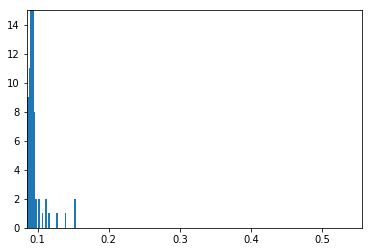

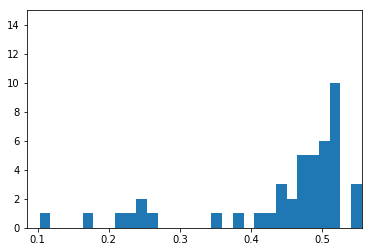

INFO:tensorflow:Restoring parameters from ./checkpoints/test_4_siamese_final.ckpt
conv1  [None, 15, 20, 64]
conv2  [None, 8, 10, 64]
conv3  [None, 4, 5, 64]
encoded  [None, 4, 5, 64]
reshape3  [None, 4, 5, 64]
reshape2  [None, 8, 10, 64]
reshape1  [None, 15, 20, 64]
outputs  [None, 60, 80, 3]
good_losses min 0.08428755
good_losses max 0.14325821
Number of false positives  0
Number of true negatives  425
anomoly_losses min 0.10096025
anomoly_losses max 0.55672723
Number of false negatives  33
Number of true positives  220
Sensitivity :  0.8695652173913043
Specificity :  1.0
Precision :  1.0
Recall :  0.8695652173913043
FScore :  0.9302325581395349


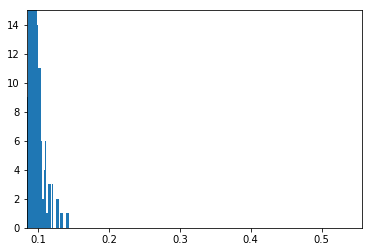

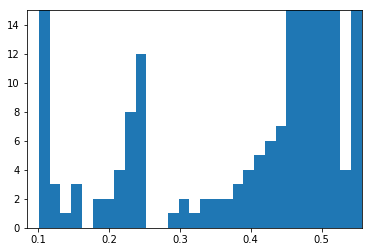

In [52]:
checkpoint_file = './checkpoints/test_4_siamese_final.ckpt'
# checkpoint_file=tf.train.latest_checkpoint('./checkpoints/')
score_model(g_test, a_test , threshold = .2145, checkpoint_file=checkpoint_file)
score_model(g_train, a_train , threshold = .2145, checkpoint_file=checkpoint_file)

In [24]:
tf.train.latest_checkpoint('./checkpoints/')

'./checkpoints/test_4_siamese_final.ckpt'

In [ ]:
reconstruct_image(np.random.choice(normal_names,1), tf.train.latest_checkpoint('./checkpoints/')) 

In [ ]:
train_g_results.hist(column='recon_errors')

In [ ]:
tf.train.latest_checkpoint('./checkpoints/')